In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.contrib.slim as slim

import urllib2

from tensorflow.contrib.slim.python.slim.nets import vgg
import vgg_preprocessing
import imagenet

#import imagenet
checkpoints_dir = './'

In [2]:
# We need default size of image for a particular network.
# The network was trained on images of that size -- so we
# resize input image later in the code.
image_size = vgg.vgg_16.default_image_size


INFO:tensorflow:Restoring parameters from ./vgg_16.ckpt


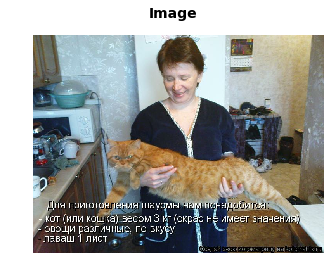

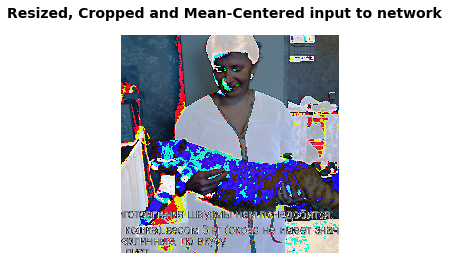

Probability 0.59 => [lynx, catamount]
Probability 0.07 => [tiger cat]
Probability 0.07 => [Egyptian cat]
Probability 0.04 => [cougar, puma, catamount, mountain lion, painter, panther, Felis concolor]
Probability 0.04 => [dhole, Cuon alpinus]


In [4]:
with tf.Graph().as_default():
    url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/"+\
           "First_Student_IC_school_bus_202076.jpg")
    url = ("http://kotomatrix.ru/images/lolz/2010/12/09/760819.jpg")
    # Open specified url and load image as a string
    image_string = urllib2.urlopen(url).read()

    # Decode string into matrix with intensity values
    image = tf.image.decode_jpeg(image_string, channels=3)

    # Resize the input image, preserving the aspect ratio
    # and make a central crop of the resulted image.
    # The crop will be of the size of the default image size of
    # the network.
    processed_image = vgg_preprocessing.preprocess_image(image,
                                                         image_size,
                                                         image_size,
                                                         is_training=False)

    # Networks accept images in batches.
    # The first dimension usually represents the batch size.
    # In our case the batch size is one.
    processed_images = tf.expand_dims(processed_image, 0)

    # Create the model, use the default arg scope to configure
    # the batch norm parameters. arg_scope is a very conveniet
    # feature of slim library -- you can define default
    # parameters for layers -- like stride, padding etc.
    with slim.arg_scope(vgg.vgg_arg_scope()):
        logits, _ = vgg.vgg_16(processed_images,
                               num_classes=1000,
                               is_training=False)

    # In order to get probabilities we apply softmax on the output.
    probabilities = tf.nn.softmax(logits)

    # Create a function that reads the network weights
    # from the checkpoint file that you downloaded.
    # We will run it in session later.
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))

    with tf.Session() as sess:
        # Load weights
        init_fn(sess)

        # We want to get predictions, image as numpy matrix
        # and resized and cropped piece that is actually
        # being fed to the network.
        np_image, network_input, probabilities = sess.run([image,
                                                           processed_image,
                                                           probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities),
                                            key=lambda x: x[1])]

    # Show the downloaded image
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.suptitle("Image", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

    # Show the image that is actually being fed to the network
    # The image was resized while preserving aspect ratio and then
    # cropped. After that, the mean pixel value was subtracted from
    # each pixel of that crop. We normalize the image to be between [-1, 1]
    # to show the image.
    plt.imshow(network_input / (network_input.max() - network_input.min()))
    plt.suptitle("Resized, Cropped and Mean-Centered input to network",
                 fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        # Now we print the top-5 predictions that the network gives us with
        # corresponding probabilities. Pay attention that the index with
        # class names is shifted by 1 -- this is because some networks
        # were trained on 1000 classes and others on 1001. VGG-16 was trained
        # on 1000 classes.
        print('Probability %0.2f => [%s]' % (probabilities[index], names[index + 1]))

    res = slim.get_model_variables()